<a href="https://colab.research.google.com/github/bcdmodelos/qualificacao-modelscode/blob/main/Modelo-GPR/codigo_modelo_gpr_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise por Regressão por Processos Gaussianos para o Brasil

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
%cd /content/drive/MyDrive/Notebooks_Doutorado/base-campina/

!ls

/content/drive/MyDrive/Notebooks_Doutorado/base-campina
dataset_Amazonas_usableData.csv
dataset_Bodocongo_usable.csv
dataset_Brasil_usableData.csv
dataset_CampinaGrande_casos_acumulados_usable.csv
dataset_CampinaGrande_casos_diarios_usable.csv
dataset_CampinaGrande_usableData.csv
dataset_Catole_usable.csv
dataset_Malvinas_usable.csv
dataset_Paraiba_usableData.csv
dataset_Pernambuco_usableData.csv


In [5]:
file_path = "./dataset_Brasil_usableData.csv"
casosBrasil = pd.read_csv(file_path, encoding='latin1')
casosBrasil.head()

,Unnamed: 0,date,totalCases,deaths,suspects,recovered,tests,vaccinated,vaccinated_second,activeCases,newVaccinated,newVaccinated_second
0,293,2020-03-22,1594,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,321,2020-03-23,1952,34,15867.0,8.0,NaN,NaN,NaN,1910.0,NaN,NaN
2,349,2020-03-24,2255,47,17700.0,20.0,NaN,NaN,NaN,2188.0,NaN,NaN
3,377,2020-03-25,2566,59,27227.0,27.0,NaN,NaN,NaN,2480.0,NaN,NaN
4,405,2020-03-26,2990,77,50012.0,42.0,NaN,NaN,NaN,2871.0,NaN,NaN


In [6]:
dfBrasil  = casosBrasil.iloc[:,[1,2]]
dfBrasil

,date,totalCases
0,2020-03-22,1594
1,2020-03-23,1952
2,2020-03-24,2255
3,2020-03-25,2566
4,2020-03-26,2990
...,...,...
462,2021-06-27,18422493
463,2021-06-28,18454542
464,2021-06-29,18520490
465,2021-06-30,18567618


# Visualização dos Dataset's de número de casos acumulados

Text(0.5, 0, 'Dia')

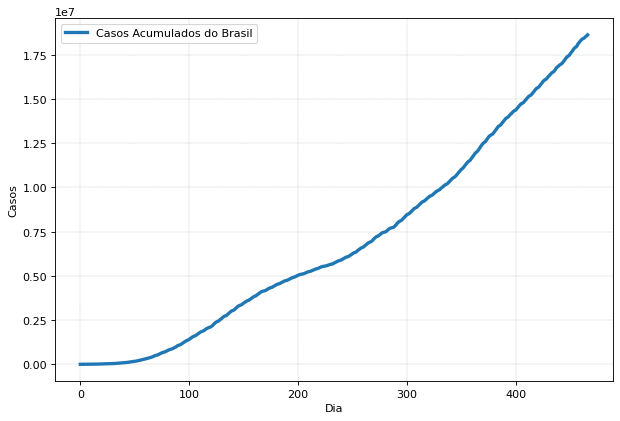

In [8]:
data = np.array(dfBrasil.totalCases.values)
data = data.reshape(-1, 1)

CRdata = data/1000
CRdata  = np.ravel(CRdata)

plt.figure(2, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['Casos Acumulados do Brasil'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos')
plt.xlabel('Dia')

Dataset de teste

In [9]:
trainL = len(CRdata) - 30

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]

In [10]:
def half_data(data, time):
    half_data = []
    half_time = []
    for i,item in enumerate(data):
        if i%2 == 0:
            half_data.append(item)
            half_time.append(time[i])

    return np.array(half_data), np.array(half_time)

Modelagem

In [11]:
def GPR_Model(CR_tr, t_tr, CR_test, t_test):

    t = np.append(t_tr, t_test).reshape(-1,1)
    CRdata = np.append(CR_tr, CR_test)

    #kernel = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()
    kernel = ConstantKernel()*RBF()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)
    # kernel = RBF()
    # kernel = Matern()

    model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

    model.fit(t_tr, CR_tr)
    print("\nLearned kernel: %s" % model.kernel_)
    params = model.kernel_.get_params()

    R2_tr  = model.score(t_tr, CR_tr)
    R2     = model.score(t, CRdata)
    R2_test = model.score(t_test, CR_test)

    CRpred_tr, sigma_tr = model.predict(t_tr, return_std=True)
    CRpred_test, sigma_test = model.predict(t_test, return_std=True)
    CRpred, sigma   = model.predict(t, return_std=True)

    MSE = np.mean(((CRpred_tr-CR_tr)*1000)**2)
    print("\nMSE: %f" % MSE)
    print("\nSTD: %f" % np.sqrt(MSE))
    print("\nR2 treinamento: %f" % R2_tr)
    print("\nR2 todo intervalo de dados: %f" % R2)
    print("\nR2 de teste: %f" % R2_test)

    return CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata

In [12]:
CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata = GPR_Model(CR_tr, t_tr, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 12.2**2 * RBF(length_scale=5.37) * DotProduct(sigma_0=0.116) * 1.29**2

MSE: 16445029.135294

STD: 4055.247111

R2 treinamento: 0.999999

R2 todo intervalo de dados: 0.640430

R2 de teste: -479.051860


In [15]:
def plot_gpr(CRdata, CRpred, sigma, t):
    plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    mpl.style.use('default')
    plt.plot(t, CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados Brasil')
    plt.axvline(x = t_test[0],linestyle= '--', color = 'black')
    plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)
    plt.fill(np.concatenate([t, t[::-1]]),
            np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                            (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
            alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
    plt.legend(loc='upper left', fontsize = 14)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylabel('Total de casos', fontsize = 14)
    plt.xlabel('dia', fontsize = 14)
    plt.title('COVID-CG Casos Acumulados', fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

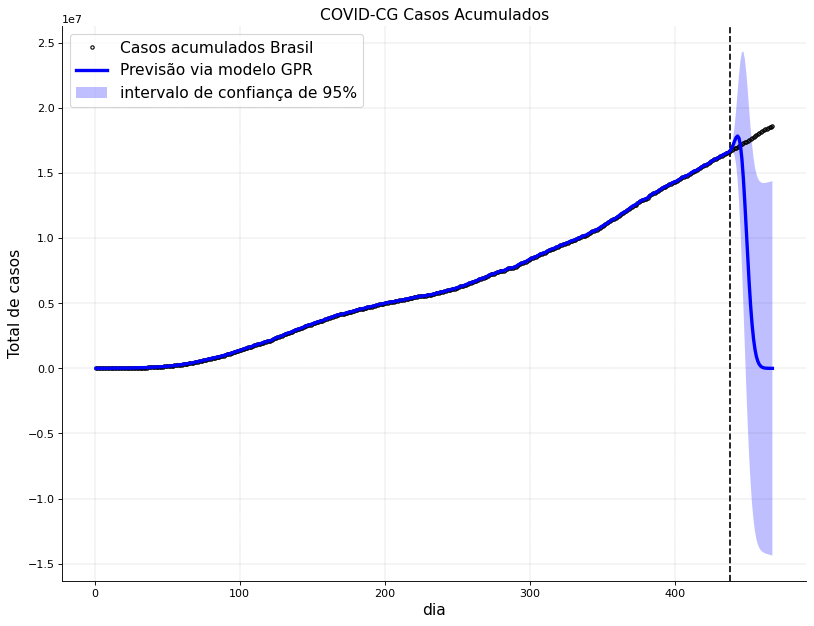

In [16]:
plot_gpr(CRdata, CRpred, sigma, t)

Análise para 50% dos dados

In [17]:
CR_tr_half,t_tr_half = half_data(CR_tr, t_tr)

In [18]:
CRpred_tr_half, sigma_tr_half, CRpred_test_half, sigma_test_half, CRpred_half, sigma_half, t_half, CRdata_half = GPR_Model(CR_tr_half, t_tr_half, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 1.44**2 * RBF(length_scale=5.12) * DotProduct(sigma_0=0.00847) * 3.55**2

MSE: 15632947.940525

STD: 3953.852291

R2 treinamento: 0.999999

R2 todo intervalo de dados: 0.224169

R2 de teste: -638.571714


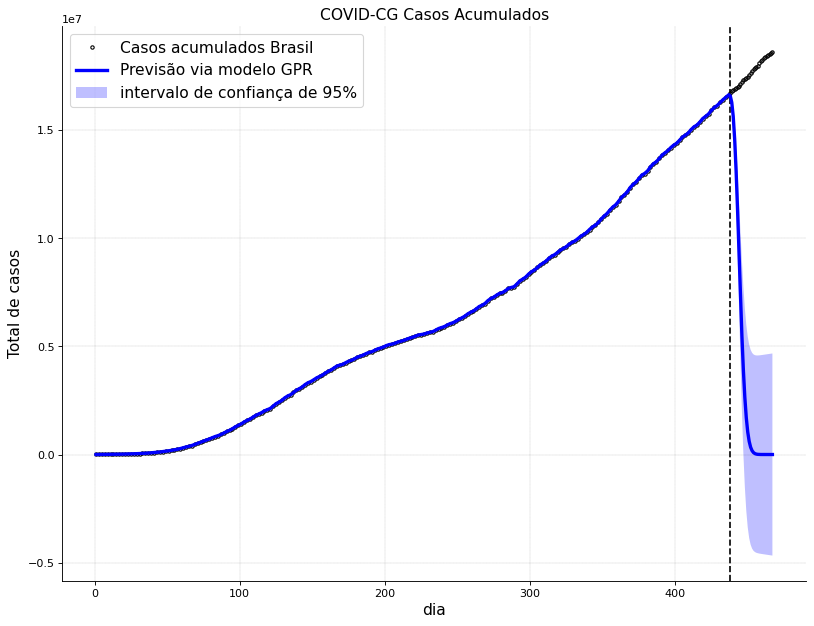

In [19]:
plot_gpr(CRdata_half, CRpred_half, sigma_half, t_half)

Análise para 1/4 dos dados

In [20]:
CR_tr_quarter,t_tr_quarter = half_data(CR_tr_half, t_tr_half)
CRpred_tr_quarter, sigma_tr_quarter, CRpred_test_quarter, sigma_test_quarter, CRpred_quarter, sigma_quarter, t_quarter, CRdata_quarter = GPR_Model(CR_tr_quarter, t_tr_quarter, CR_test, t_test)


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 8.29**2 * RBF(length_scale=7.1) * DotProduct(sigma_0=0.00174) * 1.88**2

MSE: 449583.395102

STD: 670.509802

R2 treinamento: 1.000000

R2 todo intervalo de dados: 0.054003

R2 de teste: -513.849027


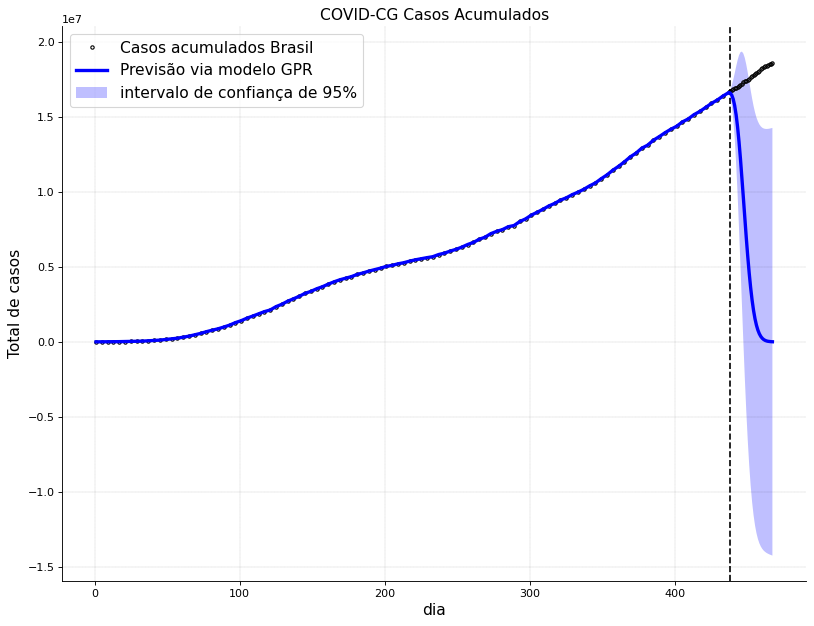

In [22]:
plot_gpr(CRdata_quarter, CRpred_quarter, sigma_quarter, t_quarter)